In [1]:
#CONDA ENV: base
#Import packages
#---------------------------------------
import sys
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pysam as sam
import meth_f as mf

#Import your modules
#---------------------------------------
sys.path.insert(1, '/cndd3/dburrows/CODE/admin_tools/')
sys.path.insert(1, '/cndd3/dburrows/CODE/te_rna_ageing/')
from admin_tools import admin_functions as adm
import te_rna_f as ter

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'
s_fig = '/cndd3/dburrows/FIGS/'

%load_ext autoreload
sys.version

'3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) \n[GCC 9.4.0]'

In [ ]:
def _group():
    

# Global methylation

In [286]:
# Load in global methylation
meth_df = pd.read_csv('/cndd2/jchien/project/Dracheva_Development/Individual_globalMethylation_autosome_cov3to50_all.tsv.gz', sep='\t', index_col=0)
meth_df['Sample ID'] = [meth_df['donor'][i] + '-' + meth_df['celltype'][i] for i in range(len(meth_df))]

# Load in RNA
rna_df = pd.read_csv('/cndd/dburrows/DATA/te/rna/PE.counts/DE/ATEM_CPM.csv', index_col=0)
rna_df.columns = [rna_df.columns[i].upper() for i in range(len(rna_df.columns))]

# Load in PE metadata
meta_df = pd.read_csv('/datasets/Public_Datasets/Dracheva_PsychEncode_development/processed/PEC_RNAmeta.csv')
#meta_df = pd.read_csv('/datasets/Public_Datasets/Dracheva_PsychEncode_development/processed/PEC_LIMS_11042022_mod.csv')

In [288]:
#Put total methylation, true methylation and hydroxymethylation into dataframe for each donor
unq = np.unique(meth_df['Sample ID'].values, return_counts=True)
rep_donors = unq[0][np.where(unq[1] > 1)[0]] #repeated donors

cmeth_df = {'total mCG': [], 'total mCH':[], 'true mCG': [], 'true mCH':[] , 
'hydroxy mCG': [], 'hydroxy mCH':[], 'Sample ID':rep_donors, 
'celltype': [], 'age': [], 'sex': [], 'age_binary': []} 
for r in rep_donors:
    
    curr = meth_df[meth_df['Sample ID'] == r]
    bs = curr[curr['assay'] == 'BS']
    ox = curr[curr['assay'] == 'oxBS']
    assert len(bs) == 1 and len(ox) == 1, 'Error: more than one, or 0 BS or oxBS sample for donor {}'.format(r)
    cmeth_df['total mCG'] = np.append(cmeth_df['total mCG'], bs['mCGlevel'].values)
    cmeth_df['total mCH'] = np.append(cmeth_df['total mCH'], bs['mCHlevel'].values)
    cmeth_df['true mCG'] = np.append(cmeth_df['true mCG'], ox['mCGlevel'].values)
    cmeth_df['true mCH'] = np.append(cmeth_df['true mCH'], ox['mCHlevel'].values)
    cmeth_df['hydroxy mCG'] = np.append(cmeth_df['hydroxy mCG'], bs['mCGlevel'].values - ox['mCGlevel'].values)
    cmeth_df['hydroxy mCH'] = np.append(cmeth_df['hydroxy mCH'], bs['mCHlevel'].values - ox['mCHlevel'].values)
    cmeth_df['celltype'] = np.append(cmeth_df['celltype'], curr['celltype'].values[0])
    cmeth_df['age'] = np.append(cmeth_df['age'], curr['age'].values[0])
    cmeth_df['sex'] = np.append(cmeth_df['sex'], curr['sex'].values[0])
    cmeth_df['age_binary'] = np.append(cmeth_df['age_binary'], curr['age_binary'].values[0])

cmeth_df = pd.DataFrame(cmeth_df)
cmeth_df


,total mCG,total mCH,true mCG,true mCH,hydroxy mCG,hydroxy mCH,Sample ID,celltype,age,sex,age_binary
0,0.836717,0.057766,0.552705,0.048780,0.284011,0.008986,003-GABA,GABA,33.00,Male,(30-60]
1,0.805220,0.052205,0.459218,0.043073,0.346002,0.009133,003-GLU,GLU,33.00,Male,(30-60]
2,0.843238,0.056306,0.557717,0.049474,0.285521,0.006832,012-GABA,GABA,53.00,Male,(30-60]
3,0.819121,0.053518,0.447794,0.042064,0.371327,0.011454,012-GLU,GLU,53.00,Male,(30-60]
4,0.838394,0.055726,0.549151,0.050949,0.289243,0.004778,061-GABA,GABA,43.00,Male,(30-60]
...,...,...,...,...,...,...,...,...,...,...,...
164,0.824762,0.055118,0.445185,0.043303,0.379577,0.011814,HCTYPA008-GLU,GLU,75.53,Male,"(60,75]"
165,0.844100,0.052441,0.530001,0.044715,0.314099,0.007726,HCTZZHA019-GABA,GABA,NaN,nan,nan
166,0.817749,0.050561,0.443184,0.039483,0.374565,0.011079,HCTZZHA019-GLU,GLU,NaN,nan,nan
167,0.832042,0.052850,0.545656,0.047485,0.286385,0.005365,HCTZZNA014-GABA,GABA,39.19,Female,(30-60]


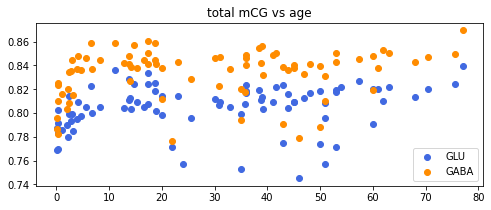

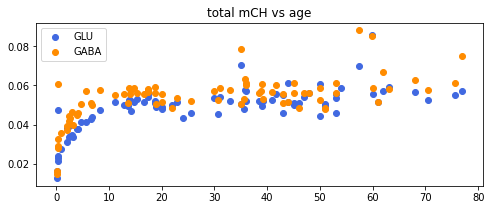

In [291]:
#Plot true methylation vs age
fig, ax = plt.subplots(figsize=(8, 3))
glu = cmeth_df[cmeth_df['celltype'] == 'GLU']
gaba = cmeth_df[cmeth_df['celltype'] == 'GABA']
string = 'total'
plt.title(string+ ' mCG vs age')
plt.scatter(glu['age'], glu[string + ' mCG'], label='GLU', c='royalblue')
plt.scatter(gaba['age'], gaba[string + ' mCG'], label='GABA', c='darkorange')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
plt.title(string+' mCH vs age')
plt.scatter(glu['age'], glu[string + ' mCH'], label='GLU', c='royalblue')
plt.scatter(gaba['age'], gaba[string + ' mCH'], label='GABA', c='darkorange')
plt.legend()
plt.show()

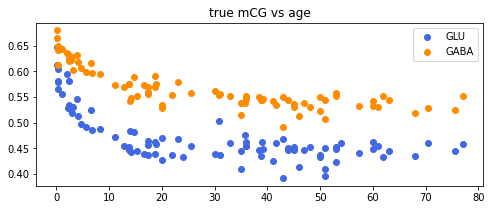

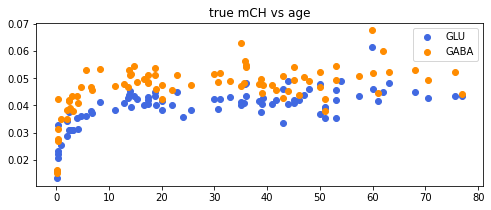

In [292]:
#Plot true methylation vs age
fig, ax = plt.subplots(figsize=(8, 3))
glu = cmeth_df[cmeth_df['celltype'] == 'GLU']
gaba = cmeth_df[cmeth_df['celltype'] == 'GABA']
string = 'true'
plt.title(string+ ' mCG vs age')
plt.scatter(glu['age'], glu[string + ' mCG'], label='GLU', c='royalblue')
plt.scatter(gaba['age'], gaba[string + ' mCG'], label='GABA', c='darkorange')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
plt.title(string+' mCH vs age')
plt.scatter(glu['age'], glu[string + ' mCH'], label='GLU', c='royalblue')
plt.scatter(gaba['age'], gaba[string + ' mCH'], label='GABA', c='darkorange')
plt.legend()
plt.show()

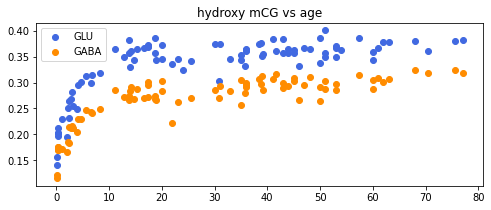

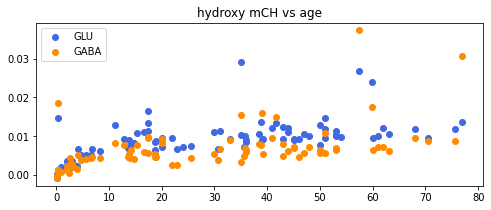

In [293]:
#Plot true methylation vs age
fig, ax = plt.subplots(figsize=(8, 3))
glu = cmeth_df[cmeth_df['celltype'] == 'GLU']
gaba = cmeth_df[cmeth_df['celltype'] == 'GABA']
string = 'hydroxy'
plt.title(string+ ' mCG vs age')
plt.scatter(glu['age'], glu[string + ' mCG'], label='GLU', c='royalblue')
plt.scatter(gaba['age'], gaba[string + ' mCG'], label='GABA', c='darkorange')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
plt.title(string+' mCH vs age')
plt.scatter(glu['age'], glu[string + ' mCH'], label='GLU', c='royalblue')
plt.scatter(gaba['age'], gaba[string + ' mCH'], label='GABA', c='darkorange')
plt.legend()
plt.show()

In [329]:
def groupby_coarse(curr_df, name):
    ind = [x for x,i in enumerate(curr_df.index) if name in i]#l1 ind
    cpm_v = [np.mean(curr_df.iloc[ind][i])for i in int_list]
    return(cpm_v)

In [328]:
#======================
# RNA VS METHYLATION
#======================

#Filter low CPM RNA data
thresh = 1 
ind = np.mean(rna_df, axis=1) >thresh #indeces of ones to keep
curr_df = rna_df.loc[ind]

In [341]:
#Append RNA data to methylation dataframe
#----------------------------------------------------------
#Find intersection between RNA and methylation data
int_list = np.intersect1d(curr_df.columns, meth_df['Sample ID'].unique())
meth_rna_df = pd.DataFrame()
for i in int_list:
    meth_rna_df = pd.concat([meth_rna_df, cmeth_df[cmeth_df['Sample ID']==i]], axis=0)
meth_rna_df['L1'] = groupby_coarse(curr_df, 'L1')
meth_rna_df['Alu'] = groupby_coarse(curr_df, 'Alu')
meth_rna_df['SVA'] = groupby_coarse(curr_df, 'SVA')

In [343]:
meth_rna_df

,total mCG,total mCH,true mCG,true mCH,hydroxy mCG,hydroxy mCH,Sample ID,celltype,age,sex,age_binary,L1,Alu,SVA
16,0.854853,0.055868,0.549036,0.048003,0.305817,0.007865,1133-GABA,GABA,38.49,Male,(30-60],4.283278,113.351027,3.727624
17,0.819483,0.052056,0.445715,0.041518,0.373768,0.010538,1133-GLU,GLU,38.49,Male,(30-60],4.747331,125.072761,4.163051
18,0.850587,0.060416,0.534116,0.045519,0.316472,0.014897,1134-GABA,GABA,41.69,Male,(30-60],3.776852,89.799221,2.118406
19,0.822146,0.055410,0.460821,0.042019,0.361326,0.013392,1134-GLU,GLU,41.69,Male,(30-60],3.789104,92.627928,2.704041
20,0.856226,0.060604,0.544437,0.044660,0.311789,0.015944,1241-GABA,GABA,39.00,Male,(30-60],4.052877,121.539998,4.107520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.784637,0.033835,0.530181,0.030979,0.254455,0.002856,HCT17HEIA010-GLU,GLU,3.19,Female,"[0,10]",4.856014,108.695440,2.837427
163,0.849728,0.061016,0.524638,0.052251,0.325090,0.008765,HCTYPA008-GABA,GABA,75.53,Male,"(60,75]",5.930871,146.475940,5.064952
164,0.824762,0.055118,0.445185,0.043303,0.379577,0.011814,HCTYPA008-GLU,GLU,75.53,Male,"(60,75]",5.947582,146.706183,5.552370
167,0.832042,0.052850,0.545656,0.047485,0.286385,0.005365,HCTZZNA014-GABA,GABA,39.19,Female,(30-60],4.864696,143.033759,5.029634


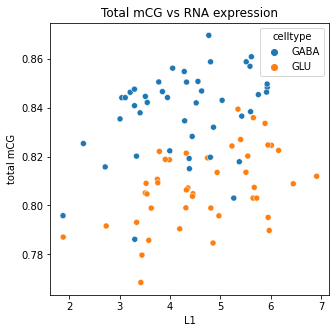

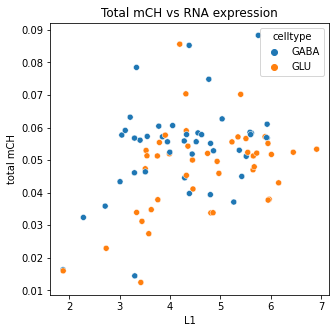

In [347]:
#Plot total methylation against RNA expression
import seaborn as sns
fig,ax = plt.subplots(figsize=(5, 5))
plt.title('Total mCG vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="L1", y="total mCG", hue="celltype")
plt.show()

fig,ax = plt.subplots(figsize=(5, 5))
plt.title('Total mCH vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="L1", y="total mCH", hue="celltype")
plt.show()

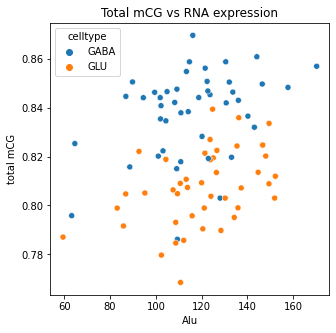

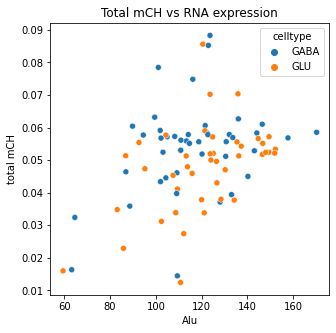

In [357]:
#Plot total methylation against RNA expression
import seaborn as sns
fig,ax = plt.subplots(figsize=(5, 5))
plt.title('Total mCG vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="Alu", y="total mCG", hue="celltype")
plt.show()

fig,ax = plt.subplots(figsize=(5, 5))
plt.title('Total mCH vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="Alu", y="total mCH", hue="celltype")
plt.show()

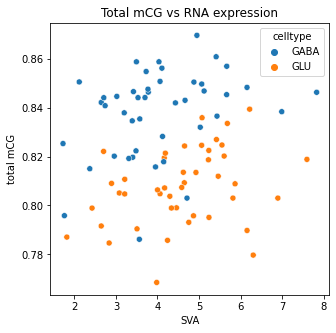

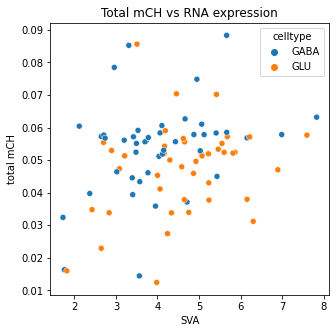

In [360]:
#Plot total methylation against RNA expression
import seaborn as sns
fig,ax = plt.subplots(figsize=(5, 5))
plt.title('Total mCG vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="SVA", y="total mCG", hue="celltype")
plt.show()

fig,ax = plt.subplots(figsize=(5, 5))
plt.title('Total mCH vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="SVA", y="total mCH", hue="celltype")
plt.show()

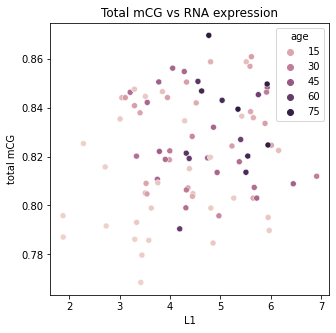

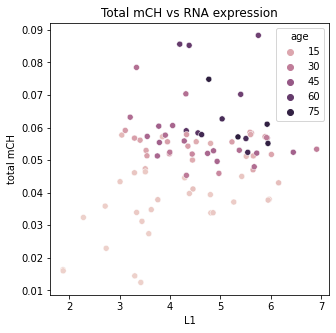

In [353]:
#Plot total methylation against RNA expression
import seaborn as sns
fig,ax = plt.subplots(figsize=(5, 5))
plt.title('Total mCG vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="L1", y="total mCG", hue="age")
plt.show()

fig,ax = plt.subplots(figsize=(5, 5))
plt.title('Total mCH vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="L1", y="total mCH", hue="age")
plt.show()

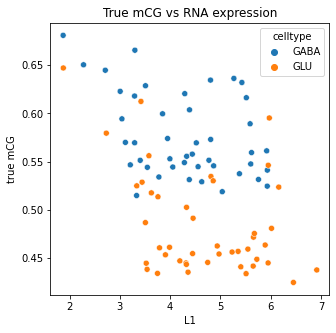

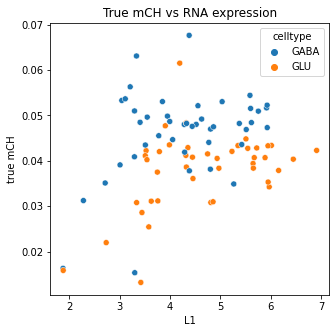

In [348]:
#Plot true methylation against RNA expression
import seaborn as sns
fig,ax = plt.subplots(figsize=(5, 5))
plt.title('True mCG vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="L1", y="true mCG", hue="celltype")
plt.show()

fig,ax = plt.subplots(figsize=(5, 5))
plt.title('True mCH vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="L1", y="true mCH", hue="celltype")
plt.show()

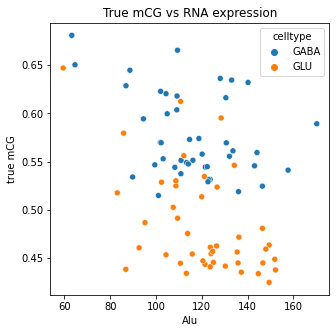

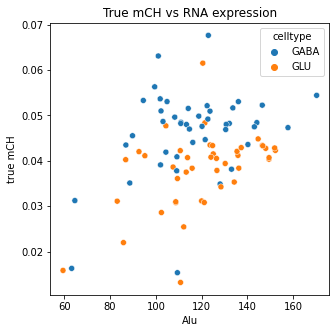

In [358]:
#Plot true methylation against RNA expression
import seaborn as sns
fig,ax = plt.subplots(figsize=(5, 5))
plt.title('True mCG vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="Alu", y="true mCG", hue="celltype")
plt.show()

fig,ax = plt.subplots(figsize=(5, 5))
plt.title('True mCH vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="Alu", y="true mCH", hue="celltype")
plt.show()

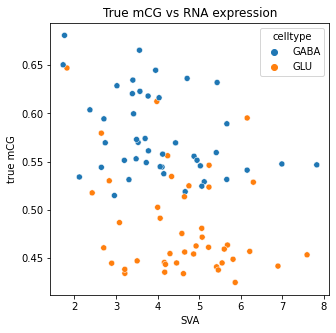

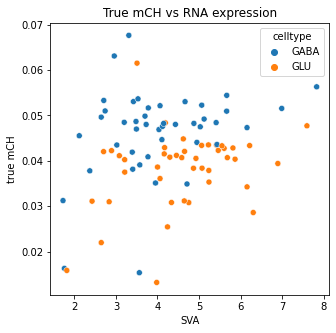

In [361]:
#Plot true methylation against RNA expression
import seaborn as sns
fig,ax = plt.subplots(figsize=(5, 5))
plt.title('True mCG vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="SVA", y="true mCG", hue="celltype")
plt.show()

fig,ax = plt.subplots(figsize=(5, 5))
plt.title('True mCH vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="SVA", y="true mCH", hue="celltype")
plt.show()

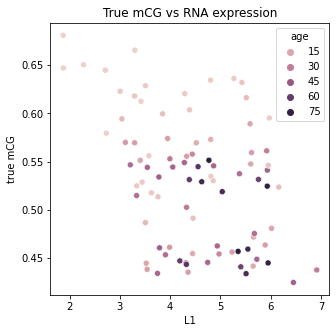

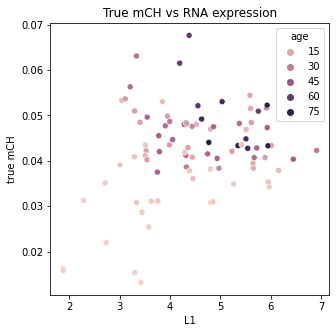

In [356]:
#Plot true methylation against RNA expression
import seaborn as sns
fig,ax = plt.subplots(figsize=(5, 5))
plt.title('True mCG vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="L1", y="true mCG", hue="age")
plt.show()

fig,ax = plt.subplots(figsize=(5, 5))
plt.title('True mCH vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="L1", y="true mCH", hue="age")
plt.show()

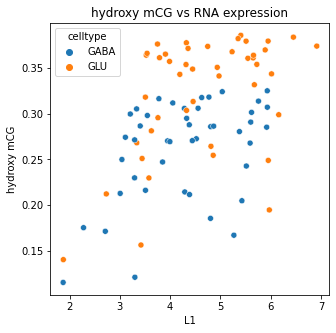

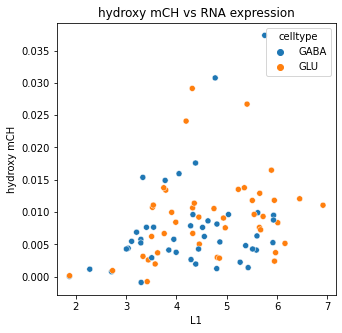

In [349]:
#Plot total methylation against RNA expression
import seaborn as sns
fig,ax = plt.subplots(figsize=(5, 5))
plt.title('hydroxy mCG vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="L1", y="hydroxy mCG", hue="celltype")
plt.show()

fig,ax = plt.subplots(figsize=(5, 5))
plt.title('hydroxy mCH vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="L1", y="hydroxy mCH", hue="celltype")
plt.show()

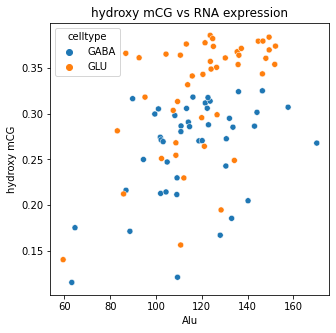

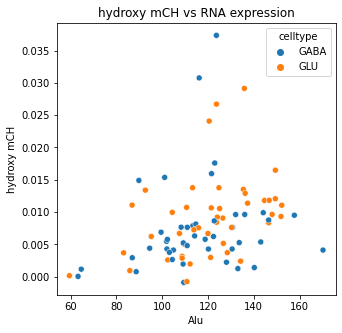

In [359]:
#Plot total methylation against RNA expression
import seaborn as sns
fig,ax = plt.subplots(figsize=(5, 5))
plt.title('hydroxy mCG vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="Alu", y="hydroxy mCG", hue="celltype")
plt.show()

fig,ax = plt.subplots(figsize=(5, 5))
plt.title('hydroxy mCH vs RNA expression')
sns.scatterplot(data=meth_rna_df, x="Alu", y="hydroxy mCH", hue="celltype")
plt.show()

# TE site methylation

In [41]:
path = '/cndd/emukamel/DrachevaLiu_PsychENCODE_SCZ/Line1_mC/'
df=pd.read_csv(path+f'/binc_RefL1_multi.mC.all_samples.tsv.gz',sep='\t',header=[0,1,2,3],index_col=[0,1],
#                nrows=10000
              )

In [42]:
# Remove "multi" from the RefL1_id
df.index.names=['RefL1_id','bin']
dfi = df.index.to_frame()
dfi['RefL1_id']=dfi['RefL1_id'].str.replace('_multi','')
dfi = pd.MultiIndex.from_frame(dfi)
df.index = dfi

In [12]:
df

measure                   mCGN         mCHN        mCGN        mCHN mCGN mCHN  \
sample            HCT16HECA028 HCT16HECA028 198035-1765 198035-1765 4413 4413   
celltype                   Glu          Glu         Glu         Glu  Glu  Glu   
mctype                      BS           BS        OxBS        OxBS OxBS OxBS   
RefL1_id   bin                                                                  
RefL1_0    -10752          NaN          NaN         NaN         NaN  NaN  NaN   
           -10624          NaN       0.0000         NaN         NaN  NaN  NaN   
           -10496          NaN       0.0000         NaN         NaN  NaN  NaN   
           -9728           NaN       0.0345         NaN         NaN  NaN  NaN   
           -9600           NaN       0.0741         NaN         NaN  NaN  0.0   
...                        ...          ...         ...         ...  ...  ...   
RefL1_1067 -8448           NaN          NaN         NaN         NaN  NaN  NaN   
RefL1_3140  6528           NaN          NaN         NaN         NaN  NaN  NaN   
RefL1_3583 -5504           NaN          NaN         NaN         NaN  NaN  NaN   
RefL1_6246  8192           NaN          NaN         NaN         NaN  NaN  NaN   
RefL1_1067  9088           NaN          NaN         NaN         NaN  NaN  NaN   

measure              mCGN    mCHN mCGN    mCHN  ... mCGN mCHN mCGN mCHN mCGN  \
sample               5643    5643 4414    4414  ... 4414 4414 1275 1275 5977   
celltype              Glu     Glu GABA    GABA  ...  Glu  Glu  Glu  Glu GABA   
mctype                 BS      BS   BS      BS  ...   BS   BS   BS   BS   BS   
RefL1_id   bin                                  ...                            
RefL1_0    -10752  0.3333  0.0000  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN   
           -10624     NaN  0.0000  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN   
           -10496     NaN  0.0000  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN   
           -9728      NaN     NaN  NaN  0.0000  ...  NaN  NaN  NaN  NaN  NaN   
           -9600      NaN  0.0588  NaN  0.0256  ...  NaN  NaN  NaN  NaN  NaN   
...                   ...     ...  ...     ...  ...  ...  ...  ...  ...  ...   
RefL1_1067 -8448      NaN     NaN  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN   
RefL1_3140  6528      NaN     NaN  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN   
RefL1_3583 -5504      NaN     NaN  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN   
RefL1_6246  8192      NaN     NaN  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN   
RefL1_1067  9088      NaN     NaN  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN   

measure           mCHN       mCGN       mCHN mCGN mCHN  
sample            5977 HCTZZNA014 HCTZZNA014 4379 4379  
celltype          GABA        Glu        Glu  Glu  Glu  
mctype              BS       oxBS       oxBS OxBS OxBS  
RefL1_id   bin                                          
RefL1_0    -10752  NaN        NaN        NaN  NaN  NaN  
           -10624  NaN        NaN        NaN  NaN  NaN  
           -10496  NaN        NaN        NaN  NaN  NaN  
           -9728   NaN        NaN     0.0556  NaN  NaN  
           -9600   NaN        NaN     0.0238  NaN  NaN  
...                ...        ...        ...  ...  ...  
RefL1_1067 -8448   NaN        NaN        NaN  NaN  NaN  
RefL1_3140  6528   NaN        NaN        NaN  NaN  NaN  
RefL1_3583 -5504   NaN        NaN        NaN  NaN  NaN  
RefL1_6246  8192   NaN        NaN        NaN  NaN  NaN  
RefL1_1067  9088   NaN        NaN        NaN  NaN  NaN  

[1991527 rows x 464 columns]

In [43]:
df=df.reorder_levels(['mctype','sample','measure','celltype'],axis=1)
df

mctype                      BS                OxBS                     BS  \
sample            HCT16HECA028         198035-1765      4413         5643   
measure                   mCGN    mCHN        mCGN mCHN mCGN mCHN    mCGN   
celltype                   Glu     Glu         Glu  Glu  Glu  Glu     Glu   
RefL1_id   bin                                                              
RefL1_0    -10752          NaN     NaN         NaN  NaN  NaN  NaN  0.3333   
           -10624          NaN  0.0000         NaN  NaN  NaN  NaN     NaN   
           -10496          NaN  0.0000         NaN  NaN  NaN  NaN     NaN   
           -9728           NaN  0.0345         NaN  NaN  NaN  NaN     NaN   
           -9600           NaN  0.0741         NaN  NaN  NaN  0.0     NaN   
...                        ...     ...         ...  ...  ...  ...     ...   
RefL1_1067 -8448           NaN     NaN         NaN  NaN  NaN  NaN     NaN   
RefL1_3140  6528           NaN     NaN         NaN  NaN  NaN  NaN     NaN   
RefL1_3583 -5504           NaN     NaN         NaN  NaN  NaN  NaN     NaN   
RefL1_6246  8192           NaN     NaN         NaN  NaN  NaN  NaN     NaN   
RefL1_1067  9088           NaN     NaN         NaN  NaN  NaN  NaN     NaN   

mctype                                  ...                                \
sample                    4414          ...           1275      5977        
measure              mCHN mCGN    mCHN  ... mCGN mCHN mCGN mCHN mCGN mCHN   
celltype              Glu GABA    GABA  ...  Glu  Glu  Glu  Glu GABA GABA   
RefL1_id   bin                          ...                                 
RefL1_0    -10752  0.0000  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   
           -10624  0.0000  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   
           -10496  0.0000  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   
           -9728      NaN  NaN  0.0000  ...  NaN  NaN  NaN  NaN  NaN  NaN   
           -9600   0.0588  NaN  0.0256  ...  NaN  NaN  NaN  NaN  NaN  NaN   
...                   ...  ...     ...  ...  ...  ...  ...  ...  ...  ...   
RefL1_1067 -8448      NaN  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   
RefL1_3140  6528      NaN  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   
RefL1_3583 -5504      NaN  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   
RefL1_6246  8192      NaN  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   
RefL1_1067  9088      NaN  NaN     NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   

mctype                  oxBS         OxBS       
sample            HCTZZNA014         4379       
measure                 mCGN    mCHN mCGN mCHN  
celltype                 Glu     Glu  Glu  Glu  
RefL1_id   bin                                  
RefL1_0    -10752        NaN     NaN  NaN  NaN  
           -10624        NaN     NaN  NaN  NaN  
           -10496        NaN     NaN  NaN  NaN  
           -9728         NaN  0.0556  NaN  NaN  
           -9600         NaN  0.0238  NaN  NaN  
...                      ...     ...  ...  ...  
RefL1_1067 -8448         NaN     NaN  NaN  NaN  
RefL1_3140  6528         NaN     NaN  NaN  NaN  
RefL1_3583 -5504         NaN     NaN  NaN  NaN  
RefL1_6246  8192         NaN     NaN  NaN  NaN  
RefL1_1067  9088         NaN     NaN  NaN  NaN  

[1991527 rows x 464 columns]

In [44]:
df=pd.concat({'mC':df['OxBS'], 'hmC':df['BS']-df['OxBS']},axis=1,names=['mctype'])
df

mctype                     mC                                                 \
sample            198035-1765      4413      198034-1435      4428      6007   
measure                  mCGN mCHN mCGN mCHN        mCGN mCHN mCGN mCHN mCGN   
celltype                  Glu  Glu  Glu  Glu        GABA GABA GABA GABA  Glu   
RefL1_id   bin                                                                 
RefL1_0    -10752         NaN  NaN  NaN  NaN         NaN  NaN  NaN  NaN  NaN   
           -10624         NaN  NaN  NaN  NaN         NaN  NaN  NaN  NaN  NaN   
           -10496         NaN  NaN  NaN  NaN         NaN  NaN  NaN  NaN  NaN   
           -9728          NaN  NaN  NaN  NaN         NaN  NaN  NaN  NaN  NaN   
           -9600          NaN  NaN  NaN  0.0         NaN  0.0  NaN  NaN  NaN   
...                       ...  ...  ...  ...         ...  ...  ...  ...  ...   
RefL1_1067 -8448          NaN  NaN  NaN  NaN         NaN  NaN  NaN  NaN  NaN   
RefL1_3140  6528          NaN  NaN  NaN  NaN         NaN  NaN  NaN  NaN  NaN   
RefL1_3583 -5504          NaN  NaN  NaN  NaN         NaN  NaN  NaN  NaN  NaN   
RefL1_6246  8192          NaN  NaN  NaN  NaN         NaN  NaN  NaN  NaN  NaN   
RefL1_1067  9088          NaN  NaN  NaN  NaN         NaN  NaN  NaN  NaN  NaN   

mctype                  ...       hmC                                         \
sample                  ... HCTYPA008     HCTZZHA019              HCTZZNA014   
measure           mCHN  ...      mCHN           mCGN     mCHN           mCGN   
celltype           Glu  ...      GABA Glu       GABA Glu GABA Glu       GABA   
RefL1_id   bin          ...                                                    
RefL1_0    -10752  NaN  ...       NaN NaN        NaN NaN  NaN NaN        NaN   
           -10624  NaN  ...       NaN NaN        NaN NaN  NaN NaN        NaN   
           -10496  NaN  ...       NaN NaN        NaN NaN  NaN NaN        NaN   
           -9728   NaN  ...       NaN NaN        NaN NaN  NaN NaN        NaN   
           -9600   NaN  ...       NaN NaN        NaN NaN  NaN NaN        NaN   
...                ...  ...       ...  ..        ...  ..  ...  ..        ...   
RefL1_1067 -8448   NaN  ...       NaN NaN        NaN NaN  NaN NaN        NaN   
RefL1_3140  6528   NaN  ...       NaN NaN        NaN NaN  NaN NaN        NaN   
RefL1_3583 -5504   NaN  ...       NaN NaN        NaN NaN  NaN NaN        NaN   
RefL1_6246  8192   NaN  ...       NaN NaN        NaN NaN  NaN NaN        NaN   
RefL1_1067  9088   NaN  ...       NaN NaN        NaN NaN  NaN NaN        NaN   

mctype                          
sample                          
measure               mCHN      
celltype          Glu GABA Glu  
RefL1_id   bin                  
RefL1_0    -10752 NaN  NaN NaN  
           -10624 NaN  NaN NaN  
           -10496 NaN  NaN NaN  
           -9728  NaN  NaN NaN  
           -9600  NaN  NaN NaN  
...                ..  ...  ..  
RefL1_1067 -8448  NaN  NaN NaN  
RefL1_3140  6528  NaN  NaN NaN  
RefL1_3583 -5504  NaN  NaN NaN  
RefL1_6246  8192  NaN  NaN NaN  
RefL1_1067  9088  NaN  NaN NaN  

[1991527 rows x 348 columns]

In [16]:
l1_bed=pd.read_csv(path+f'xtea_RefL1_multi_all_KNRGL.bed',sep='\t',
                   names=['chr', 'start', 'end', 'strand', 'evol_age', 'RefL1_id', 'score','L1 class','5prime'],
                  index_col='RefL1_id')
l1_bed.index = l1_bed.index.str.replace('_multi','')
l1_bed

,chr,start,end,strand,evol_age,score,L1 class,5prime
RefL1_id,,,,,,,,
RefL1_0,chr1,440936,447357,+,6421.0,.,L1PA7,440936
RefL1_1,chr1,675912,682333,+,6421.0,.,L1PA7,675912
RefL1_2,chr1,4034646,4039971,+,5325.0,.,L1PB1,4034646
RefL1_3,chr1,7411758,7417922,-,6164.0,.,L1PA4,7417921
RefL1_4,chr1,14355445,14361840,-,6395.0,.,L1PA7,14361839
...,...,...,...,...,...,...,...,...
RefL1_9956,chrX,155567854,155573980,+,6126.0,.,L1PA3,155567854
RefL1_9957,chrX,155722806,155728823,-,6017.0,.,L1PA6,155728822
RefL1_9958,chrX,155808795,155815006,+,6211.0,.,L1PA6,155808795


In [40]:
df

sample            198035-1765            4413         198034-1435          \
measure                  mCGN    mCHN    mCGN    mCHN        mCGN    mCHN   
celltype                  Glu     Glu     Glu     Glu        GABA    GABA   
ctxt                  mCGN-mC mCHN-mC mCGN-mC mCHN-mC     mCGN-mC mCHN-mC   
RefL1_id   bin                                                              
RefL1_0    -10752         NaN     NaN     NaN     NaN         NaN     NaN   
           -10624         NaN     NaN     NaN     NaN         NaN     NaN   
           -10496         NaN     NaN     NaN     NaN         NaN     NaN   
           -9728          NaN     NaN     NaN     NaN         NaN     NaN   
           -9600          NaN     NaN     NaN     0.0         NaN     0.0   
...                       ...     ...     ...     ...         ...     ...   
RefL1_1067 -8448          NaN     NaN     NaN     NaN         NaN     NaN   
RefL1_3140  6528          NaN     NaN     NaN     NaN         NaN     NaN   
RefL1_3583 -5504          NaN     NaN     NaN     NaN         NaN     NaN   
RefL1_6246  8192          NaN     NaN     NaN     NaN         NaN     NaN   
RefL1_1067  9088          NaN     NaN     NaN     NaN         NaN     NaN   

sample               4428            6007          ... HCTYPA008           \
measure              mCGN    mCHN    mCGN    mCHN  ...      mCHN            
celltype             GABA    GABA     Glu     Glu  ...      GABA      Glu   
ctxt              mCGN-mC mCHN-mC mCGN-mC mCHN-mC  ...  mCHN-hmC mCHN-hmC   
RefL1_id   bin                                     ...                      
RefL1_0    -10752     NaN     NaN     NaN     NaN  ...       NaN      NaN   
           -10624     NaN     NaN     NaN     NaN  ...       NaN      NaN   
           -10496     NaN     NaN     NaN     NaN  ...       NaN      NaN   
           -9728      NaN     NaN     NaN     NaN  ...       NaN      NaN   
           -9600      NaN     NaN     NaN     NaN  ...       NaN      NaN   
...                   ...     ...     ...     ...  ...       ...      ...   
RefL1_1067 -8448      NaN     NaN     NaN     NaN  ...       NaN      NaN   
RefL1_3140  6528      NaN     NaN     NaN     NaN  ...       NaN      NaN   
RefL1_3583 -5504      NaN     NaN     NaN     NaN  ...       NaN      NaN   
RefL1_6246  8192      NaN     NaN     NaN     NaN  ...       NaN      NaN   
RefL1_1067  9088      NaN     NaN     NaN     NaN  ...       NaN      NaN   

sample            HCTZZHA019                            HCTZZNA014           \
measure                 mCGN              mCHN                mCGN            
celltype                GABA      Glu     GABA      Glu       GABA      Glu   
ctxt                mCGN-hmC mCGN-hmC mCHN-hmC mCHN-hmC   mCGN-hmC mCGN-hmC   
RefL1_id   bin                                                                
RefL1_0    -10752        NaN      NaN      NaN      NaN        NaN      NaN   
           -10624        NaN      NaN      NaN      NaN        NaN      NaN   
           -10496        NaN      NaN      NaN      NaN        NaN      NaN   
           -9728         NaN      NaN      NaN      NaN        NaN      NaN   
           -9600         NaN      NaN      NaN      NaN        NaN      NaN   
...                      ...      ...      ...      ...        ...      ...   
RefL1_1067 -8448         NaN      NaN      NaN      NaN        NaN      NaN   
RefL1_3140  6528         NaN      NaN      NaN      NaN        NaN      NaN   
RefL1_3583 -5504         NaN      NaN      NaN      NaN        NaN      NaN   
RefL1_6246  8192         NaN      NaN      NaN      NaN        NaN      NaN   
RefL1_1067  9088         NaN      NaN      NaN      NaN        NaN      NaN   

sample                               
measure               mCHN           
celltype              GABA      Glu  
ctxt              mCHN-hmC mCHN-hmC  
RefL1_id   bin                       
RefL1_0    -10752      NaN      NaN  
           -10624      NaN      NaN  
   

In [45]:
for d in [df]:#, df_coverage]:
  dfi=d.columns.to_frame()
  dfi['ctxt'] = dfi['measure']+'-'+dfi['mctype']
  dfi=dfi.drop(columns='mctype')
  dfi=dfi.drop(columns='measure')
  d.columns=pd.MultiIndex.from_frame(dfi)

In [46]:
binsize_show = 128
dfu=df.copy().reset_index('bin')
dfu['bin']=np.floor(dfu['bin']/binsize_show)*binsize_show
dfu=dfu.groupby(['RefL1_id','bin']).mean()

/tmp/ipykernel_292463/1204176841.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  dfu=dfu.groupby(['RefL1_id','bin']).mean()


In [35]:
dfu

sample             198035-1765            4413         198034-1435          \
measure                   mCGN    mCHN    mCGN    mCHN        mCGN    mCHN   
celltype                   Glu     Glu     Glu     Glu        GABA    GABA   
ctxt                   mCGN-mC mCHN-mC mCGN-mC mCHN-mC     mCGN-mC mCHN-mC   
RefL1_id  bin                                                                
RefL1_0   -12800.0         NaN  0.0000     NaN     NaN         NaN     NaN   
          -12672.0         NaN     NaN     NaN     NaN         NaN     NaN   
          -12544.0         NaN     NaN     NaN     NaN         NaN     NaN   
          -12416.0         NaN     NaN     NaN     NaN         NaN     NaN   
          -12288.0         NaN     NaN     NaN     NaN         NaN  0.0455   
...                        ...     ...     ...     ...         ...     ...   
RefL1_999  12160.0         0.8  0.0260     NaN  0.0000      0.4545  0.0935   
           12288.0         NaN  0.0683     NaN  0.0204         NaN  0.0645   
           12416.0         NaN  0.0462     NaN  0.0588         NaN  0.0395   
           12544.0         NaN  0.0606     NaN  0.0152         NaN  0.0688   
           12672.0         0.4  0.0274     NaN  0.1176      0.2857  0.1081   

sample                4428            6007          ... HCTYPA008           \
measure               mCGN    mCHN    mCGN    mCHN  ...      mCHN            
celltype              GABA    GABA     Glu     Glu  ...      GABA      Glu   
ctxt               mCGN-mC mCHN-mC mCGN-mC mCHN-mC  ...  mCHN-hmC mCHN-hmC   
RefL1_id  bin                                       ...                      
RefL1_0   -12800.0     NaN     NaN     NaN     NaN  ...       NaN      NaN   
          -12672.0     NaN     NaN     NaN     NaN  ...       NaN      NaN   
          -12544.0     NaN     NaN     NaN     NaN  ...       NaN      NaN   
          -12416.0     NaN     NaN     NaN     NaN  ...       NaN      NaN   
          -12288.0     NaN     NaN     NaN     NaN  ...       NaN      NaN   
...                    ...     ...     ...     ...  ...       ...      ...   
RefL1_999  12160.0     NaN  0.0400  0.6667  0.0593  ...    0.0338   0.0780   
           12288.0     NaN  0.0238     NaN  0.0229  ...   -0.0565   0.0330   
           12416.0     NaN  0.0606     NaN  0.0373  ...    0.0452   0.0339   
           12544.0     NaN  0.0496     NaN  0.0347  ...    0.0246   0.0230   
           12672.0   0.625  0.0200  0.6000  0.0787  ...    0.0555   0.0235   

sample             HCTZZHA019                            HCTZZNA014           \
measure                  mCGN              mCHN                mCGN            
celltype                 GABA      Glu     GABA      Glu       GABA      Glu   
ctxt                 mCGN-hmC mCGN-hmC mCHN-hmC mCHN-hmC   mCGN-hmC mCGN-hmC   
RefL1_id  bin                                                                  
RefL1_0   -12800.0        NaN      NaN      NaN      NaN        NaN      NaN   
          -12672.0        NaN      NaN      NaN      NaN        NaN      NaN   
          -12544.0        NaN      NaN      NaN      NaN        NaN      NaN   
          -12416.0        NaN      NaN      NaN      NaN        NaN      NaN   
          -12288.0        NaN      NaN      NaN      NaN        NaN      NaN   
...                       ...      ...      ...      ...        ...      ...   
RefL1_999  12160.0        NaN   0.8571   0.0500   0.0324        NaN      NaN   
           12288.0        NaN      NaN   0.0645  -0.0028        NaN      NaN   
           12416.0        NaN      NaN   0.0122   0.0156        NaN      NaN   
           12544.0        NaN      NaN   0.0430   0.0242        NaN      NaN   
           12672.0        0.5   0.7500  -0.0555  -0.0270        NaN      NaN   

sample                                
measure                mCHN           
celltype               GABA      Glu  
ctxt               mCHN-hmC mCHN-hmC  
RefL1_id  bin                         
RefL1_0   -12800.0      Na

In [47]:
dfu = dfu.stack(['ctxt','celltype'])


In [48]:
dfu

sample                                1133  1134  1241  1275    1277    1648  \
RefL1_id  bin      ctxt     celltype                                           
RefL1_0   -12800.0 mCHN-mC  GABA       NaN   0.0   NaN   NaN  0.0000  0.0000   
                            Glu        NaN   NaN   NaN   NaN     NaN     NaN   
          -12672.0 mCHN-mC  GABA       NaN   NaN   NaN   NaN  0.0000     NaN   
                            Glu        NaN   NaN   NaN   NaN     NaN     NaN   
          -12544.0 mCHN-mC  GABA       NaN   NaN   NaN   NaN     NaN     NaN   
...                                    ...   ...   ...   ...     ...     ...   
RefL1_999  12672.0 mCGN-mC  Glu        NaN   NaN   NaN   NaN     NaN     NaN   
                   mCHN-hmC GABA       NaN   NaN   NaN   NaN -0.0476  0.0213   
                            Glu        NaN   NaN   NaN   NaN     NaN -0.0657   
                   mCHN-mC  GABA       NaN   NaN   NaN   NaN  0.1029  0.0412   
                            Glu        NaN   NaN   NaN   NaN     NaN  0.1299   

sample                                1790  179134-1401    1823  1864  ...  \
RefL1_id  bin      ctxt     celltype                                   ...   
RefL1_0   -12800.0 mCHN-mC  GABA       NaN          NaN     NaN   NaN  ...   
                            Glu        NaN          NaN     NaN   NaN  ...   
          -12672.0 mCHN-mC  GABA       NaN          NaN     NaN   NaN  ...   
                            Glu        NaN          NaN     NaN   NaN  ...   
          -12544.0 mCHN-mC  GABA       NaN          NaN     NaN   NaN  ...   
...                                    ...          ...     ...   ...  ...   
RefL1_999  12672.0 mCGN-mC  Glu        NaN       0.4000  0.4000   NaN  ...   
                   mCHN-hmC GABA       NaN      -0.1126  0.0260   NaN  ...   
                            Glu        NaN       0.0222  0.0170   NaN  ...   
                   mCHN-mC  GABA       NaN       0.1622  0.0388   NaN  ...   
                            Glu        NaN       0.0651  0.0701   NaN  ...   

sample                                 75979  HCT15HAWA031  HCT15HBMA007  \
RefL1_id  bin      ctxt     celltype                                       
RefL1_0   -12800.0 mCHN-mC  GABA         NaN           NaN           NaN   
                            Glu          NaN           NaN           NaN   
          -12672.0 mCHN-mC  GABA         NaN           NaN           NaN   
                            Glu          NaN           NaN           NaN   
          -12544.0 mCHN-mC  GABA         NaN           NaN           NaN   
...                                      ...           ...           ...   
RefL1_999  12672.0 mCGN-mC  Glu       0.7500           NaN        0.5000   
                   mCHN-hmC GABA     -0.0185           NaN        0.0042   
                            Glu       0.0203           NaN       -0.0208   
                   mCHN-mC  GABA      0.0936           NaN        0.0769   
                            Glu       0.0677           NaN        0.0741   

sample                                HCT15HBNA032  HCT16HCQA020  \
RefL1_id  bin      ctxt     celltype                               
RefL1_0   -12800.0 mCHN-mC  GABA               NaN        0.0000   
                            Glu                NaN           NaN   
          -12672.0 mCHN-mC  GABA               NaN           NaN   
                            Glu                NaN        0.0370   
          -12544.0 mCHN-mC  GABA               NaN           NaN   
...                                            ...           ...   
RefL1_999  12672.0 mCGN-mC  Glu                NaN        0.5000   
                   mCHN-hmC GABA               NaN        0.0000   
                            Glu                NaN        0.0855   
                   mCHN-mC  GABA               NaN        0.0623   
                            Glu                NaN        0.0386   

sample                                HCT16HECA028  HCT17HEIA010  HCTY

In [49]:
dfu=dfu.reset_index().set_index('RefL1_id').join(l1_bed['L1 class'],how='left')
dfu=dfu.reset_index().set_index(['RefL1_id','bin','ctxt','celltype','L1 class'])

In [50]:
dfu

1133  1134  1241  1275    1277  \
RefL1_id  bin      ctxt     celltype L1 class                                   
RefL1_0   -12800.0 mCHN-mC  GABA     L1PA7      NaN   0.0   NaN   NaN  0.0000   
                            Glu      L1PA7      NaN   NaN   NaN   NaN     NaN   
          -12672.0 mCHN-mC  GABA     L1PA7      NaN   NaN   NaN   NaN  0.0000   
                            Glu      L1PA7      NaN   NaN   NaN   NaN     NaN   
          -12544.0 mCHN-mC  GABA     L1PA7      NaN   NaN   NaN   NaN     NaN   
...                                             ...   ...   ...   ...     ...   
RefL1_999  12672.0 mCGN-mC  Glu      L1PA3      NaN   NaN   NaN   NaN     NaN   
                   mCHN-hmC GABA     L1PA3      NaN   NaN   NaN   NaN -0.0476   
                            Glu      L1PA3      NaN   NaN   NaN   NaN     NaN   
                   mCHN-mC  GABA     L1PA3      NaN   NaN   NaN   NaN  0.1029   
                            Glu      L1PA3      NaN   NaN   NaN   NaN     NaN   

                                                 1648  1790  179134-1401  \
RefL1_id  bin      ctxt     celltype L1 class                              
RefL1_0   -12800.0 mCHN-mC  GABA     L1PA7     0.0000   NaN          NaN   
                            Glu      L1PA7        NaN   NaN          NaN   
          -12672.0 mCHN-mC  GABA     L1PA7        NaN   NaN          NaN   
                            Glu      L1PA7        NaN   NaN          NaN   
          -12544.0 mCHN-mC  GABA     L1PA7        NaN   NaN          NaN   
...                                               ...   ...          ...   
RefL1_999  12672.0 mCGN-mC  Glu      L1PA3        NaN   NaN       0.4000   
                   mCHN-hmC GABA     L1PA3     0.0213   NaN      -0.1126   
                            Glu      L1PA3    -0.0657   NaN       0.0222   
                   mCHN-mC  GABA     L1PA3     0.0412   NaN       0.1622   
                            Glu      L1PA3     0.1299   NaN       0.0651   

                                                 1823  1864  ...   75979  \
RefL1_id  bin      ctxt     celltype L1 class                ...           
RefL1_0   -12800.0 mCHN-mC  GABA     L1PA7        NaN   NaN  ...     NaN   
                            Glu      L1PA7        NaN   NaN  ...     NaN   
          -12672.0 mCHN-mC  GABA     L1PA7        NaN   NaN  ...     NaN   
                            Glu      L1PA7        NaN   NaN  ...     NaN   
          -12544.0 mCHN-mC  GABA     L1PA7        NaN   NaN  ...     NaN   
...                                               ...   ...  ...     ...   
RefL1_999  12672.0 mCGN-mC  Glu      L1PA3     0.4000   NaN  ...  0.7500   
                   mCHN-hmC GABA     L1PA3     0.0260   NaN  ... -0.0185   
                            Glu      L1PA3     0.0170   NaN  ...  0.0203   
                   mCHN-mC  GABA     L1PA3     0.0388   NaN  ...  0.0936   
                            Glu      L1PA3     0.0701   NaN  ...  0.0677   

                                               HCT15HAWA031  HCT15HBMA007  \
RefL1_id  bin      ctxt     celltype L1 class                               
RefL1_0   -12800.0 mCHN-mC  GABA     L1PA7              NaN           NaN   
                            Glu      L1PA7              NaN           NaN   
          -12672.0 mCHN-mC  GABA     L1PA7              NaN           NaN   
                            Glu      L1PA7              NaN           NaN   
          -12544.0 mCHN-mC  GABA     L1PA7              NaN           NaN   
...                                                     ...           ...   
RefL1_999  12672.0 mCGN-mC  Glu      L1PA3              NaN        0.5000   
                   mCHN-hmC GABA     L1PA3              NaN        0.0042   
                            Glu      L1PA3              NaN       -0.0208   
                   mCHN-mC  GABA     L1PA3              NaN        0.0769   
                            Glu      L1PA3              NaN        0.0741   

             

In [58]:
dfu_prac = dfu.groupby(['ctxt','celltype','bin']).mean()

In [59]:
dfu_prac

1133      1134  1241  1275      1277      1648  \
ctxt     celltype bin                                                        
mCGN-hmC GABA     -12800.0   NaN  0.214396   NaN   NaN  0.253878  0.239348   
                  -12672.0   NaN  0.226001   NaN   NaN  0.250868  0.242232   
                  -12544.0   NaN  0.239081   NaN   NaN  0.253466  0.242737   
                  -12416.0   NaN  0.200748   NaN   NaN  0.240483  0.238588   
                  -12288.0   NaN  0.226656   NaN   NaN  0.243834  0.243022   
...                          ...       ...   ...   ...       ...       ...   
mCHN-mC  Glu       12160.0   NaN       NaN   NaN   NaN       NaN  0.041885   
                   12288.0   NaN       NaN   NaN   NaN       NaN  0.041655   
                   12416.0   NaN       NaN   NaN   NaN       NaN  0.042613   
                   12544.0   NaN       NaN   NaN   NaN       NaN  0.042788   
                   12672.0   NaN       NaN   NaN   NaN       NaN  0.041956   

                            1790  179134-1401      1823  1864  ...     75979  \
ctxt     celltype bin                                          ...             
mCGN-hmC GABA     -12800.0   NaN     0.251001  0.254268   NaN  ...  0.267847   
                  -12672.0   NaN     0.256390  0.255141   NaN  ...  0.269771   
                  -12544.0   NaN     0.255684  0.253501   NaN  ...  0.270735   
                  -12416.0   NaN     0.253663  0.253971   NaN  ...  0.267221   
                  -12288.0   NaN     0.253254  0.252879   NaN  ...  0.267741   
...                          ...          ...       ...   ...  ...       ...   
mCHN-mC  Glu       12160.0   NaN     0.043230  0.045791   NaN  ...  0.045895   
                   12288.0   NaN     0.043258  0.045648   NaN  ...  0.045662   
                   12416.0   NaN     0.042751  0.045735   NaN  ...  0.045723   
                   12544.0   NaN     0.042590  0.045553   NaN  ...  0.045718   
                   12672.0   NaN     0.043188  0.045958   NaN  ...  0.045646   

                            HCT15HAWA031  HCT15HBMA007  HCT15HBNA032  \
ctxt     celltype bin                                                  
mCGN-hmC GABA     -12800.0           NaN      0.270736           NaN   
                  -12672.0           NaN      0.287132           NaN   
                  -12544.0           NaN      0.277711           NaN   
                  -12416.0           NaN      0.272058           NaN   
                  -12288.0           NaN      0.285312           NaN   
...                                  ...           ...           ...   
mCHN-mC  Glu       12160.0           NaN      0.045438           NaN   
                   12288.0           NaN      0.045005           NaN   
                   12416.0           NaN      0.045388           NaN   
                   12544.0           NaN      0.044972           NaN   
                   12672.0           NaN      0.045846           NaN   

                            HCT16HCQA020  HCT16HECA028  HCT17HEIA010  \
ctxt     celltype bin                                                  
mCGN-hmC GABA     -12800.0      0.191299           NaN           NaN   
                  -12672.0      0.178631           NaN           NaN   
                  -12544.0      0.185022           NaN           NaN   
                  -12416.0      0.182069           NaN           NaN   
                  -12288.0      0.179927           NaN           NaN   
...                                  ...           ...           ...   
mCHN-mC  Glu       12160.0      0.031378           NaN           NaN   
                   12288.0      0.030680           NaN           NaN   
                   12416.0      0.031422           NaN           NaN   
                   12544.0      0.031540           NaN           NaN   
                   12672.0      0.031399           NaN           NaN   

                            HCTYPA008  HCTZZHA019  HCTZZNA014  
ctxt     celltype bin             

In [51]:
dfu_mean=dfu.groupby(['ctxt','celltype','L1 class','bin']).mean()

In [52]:
dfu_mean

1133      1134  1241  1275      1277  \
ctxt     celltype L1 class bin                                              
mCGN-hmC GABA     L1HS     -12800.0   NaN  0.072886   NaN   NaN  0.283413   
                           -12672.0   NaN  0.318833   NaN   NaN  0.230800   
                           -12544.0   NaN  0.223577   NaN   NaN  0.286890   
                           -12416.0   NaN  0.205740   NaN   NaN  0.227829   
                           -12288.0   NaN  0.234671   NaN   NaN  0.267384   
...                                   ...       ...   ...   ...       ...   
mCHN-mC  Glu      L1PREC2   12160.0   NaN       NaN   NaN   NaN       NaN   
                            12288.0   NaN       NaN   NaN   NaN       NaN   
                            12416.0   NaN       NaN   NaN   NaN       NaN   
                            12544.0   NaN       NaN   NaN   NaN       NaN   
                            12672.0   NaN       NaN   NaN   NaN       NaN   

                                         1648  1790  179134-1401      1823  \
ctxt     celltype L1 class bin                                               
mCGN-hmC GABA     L1HS     -12800.0  0.287762   NaN     0.265216  0.268248   
                           -12672.0  0.187783   NaN     0.245077  0.230075   
                           -12544.0  0.263595   NaN     0.268172  0.276420   
                           -12416.0  0.264385   NaN     0.286959  0.290982   
                           -12288.0  0.261403   NaN     0.298982  0.269280   
...                                       ...   ...          ...       ...   
mCHN-mC  Glu      L1PREC2   12160.0  0.041047   NaN     0.037755  0.044737   
                            12288.0  0.039231   NaN     0.037217  0.044236   
                            12416.0  0.043672   NaN     0.040391  0.044449   
                            12544.0  0.027114   NaN     0.033543  0.039149   
                            12672.0  0.041725   NaN     0.035791  0.047455   

                                     1864  ...     75979  HCT15HAWA031  \
ctxt     celltype L1 class bin             ...                           
mCGN-hmC GABA     L1HS     -12800.0   NaN  ...  0.309949           NaN   
                           -12672.0   NaN  ...  0.261084           NaN   
                           -12544.0   NaN  ...  0.303702           NaN   
                           -12416.0   NaN  ...  0.287840           NaN   
                           -12288.0   NaN  ...  0.268644           NaN   
...                                   ...  ...       ...           ...   
mCHN-mC  Glu      L1PREC2   12160.0   NaN  ...  0.041930           NaN   
                            12288.0   NaN  ...  0.047799           NaN   
                            12416.0   NaN  ...  0.040521           NaN   
                            12544.0   NaN  ...  0.042467           NaN   
                            12672.0   NaN  ...  0.041967           NaN   

                                     HCT15HBMA007  HCT15HBNA032  HCT16HCQA020  \
ctxt     celltype L1 class bin                                                  
mCGN-hmC GABA     L1HS     -12800.0      0.295847           NaN      0.215793   
                           -12672.0      0.286027           NaN      0.181791   
                           -12544.0      0.269110           NaN      0.209168   
                           -12416.0      0.281077           NaN      0.173272   
                           -12288.0      0.273335           NaN      0.198404   
...                                           ...           ...           ...   
mCHN-mC  Glu      L1PREC2   12160.0      0.052032           NaN      0.029889   
                            12288.0      0.049129           NaN      0.031622   
                            12416.0      0.038716           NaN      0.030611   
                            12544.0      0.040820           NaN      0.026288   
                            12672.0      0.043015           NaN      0.025165   

   

In [60]:
dfu_prac

1133      1134  1241  1275      1277      1648  \
ctxt     celltype bin                                                        
mCGN-hmC GABA     -12800.0   NaN  0.214396   NaN   NaN  0.253878  0.239348   
                  -12672.0   NaN  0.226001   NaN   NaN  0.250868  0.242232   
                  -12544.0   NaN  0.239081   NaN   NaN  0.253466  0.242737   
                  -12416.0   NaN  0.200748   NaN   NaN  0.240483  0.238588   
                  -12288.0   NaN  0.226656   NaN   NaN  0.243834  0.243022   
...                          ...       ...   ...   ...       ...       ...   
mCHN-mC  Glu       12160.0   NaN       NaN   NaN   NaN       NaN  0.041885   
                   12288.0   NaN       NaN   NaN   NaN       NaN  0.041655   
                   12416.0   NaN       NaN   NaN   NaN       NaN  0.042613   
                   12544.0   NaN       NaN   NaN   NaN       NaN  0.042788   
                   12672.0   NaN       NaN   NaN   NaN       NaN  0.041956   

                            1790  179134-1401      1823  1864  ...     75979  \
ctxt     celltype bin                                          ...             
mCGN-hmC GABA     -12800.0   NaN     0.251001  0.254268   NaN  ...  0.267847   
                  -12672.0   NaN     0.256390  0.255141   NaN  ...  0.269771   
                  -12544.0   NaN     0.255684  0.253501   NaN  ...  0.270735   
                  -12416.0   NaN     0.253663  0.253971   NaN  ...  0.267221   
                  -12288.0   NaN     0.253254  0.252879   NaN  ...  0.267741   
...                          ...          ...       ...   ...  ...       ...   
mCHN-mC  Glu       12160.0   NaN     0.043230  0.045791   NaN  ...  0.045895   
                   12288.0   NaN     0.043258  0.045648   NaN  ...  0.045662   
                   12416.0   NaN     0.042751  0.045735   NaN  ...  0.045723   
                   12544.0   NaN     0.042590  0.045553   NaN  ...  0.045718   
                   12672.0   NaN     0.043188  0.045958   NaN  ...  0.045646   

                            HCT15HAWA031  HCT15HBMA007  HCT15HBNA032  \
ctxt     celltype bin                                                  
mCGN-hmC GABA     -12800.0           NaN      0.270736           NaN   
                  -12672.0           NaN      0.287132           NaN   
                  -12544.0           NaN      0.277711           NaN   
                  -12416.0           NaN      0.272058           NaN   
                  -12288.0           NaN      0.285312           NaN   
...                                  ...           ...           ...   
mCHN-mC  Glu       12160.0           NaN      0.045438           NaN   
                   12288.0           NaN      0.045005           NaN   
                   12416.0           NaN      0.045388           NaN   
                   12544.0           NaN      0.044972           NaN   
                   12672.0           NaN      0.045846           NaN   

                            HCT16HCQA020  HCT16HECA028  HCT17HEIA010  \
ctxt     celltype bin                                                  
mCGN-hmC GABA     -12800.0      0.191299           NaN           NaN   
                  -12672.0      0.178631           NaN           NaN   
                  -12544.0      0.185022           NaN           NaN   
                  -12416.0      0.182069           NaN           NaN   
                  -12288.0      0.179927           NaN           NaN   
...                                  ...           ...           ...   
mCHN-mC  Glu       12160.0      0.031378           NaN           NaN   
                   12288.0      0.030680           NaN           NaN   
                   12416.0      0.031422           NaN           NaN   
                   12544.0      0.031540           NaN           NaN   
                   12672.0      0.031399           NaN           NaN   

                            HCTYPA008  HCTZZHA019  HCTZZNA014  
ctxt     celltype bin             

In [63]:
dfu_show

ctxt      celltype  bin                   
mCGN-hmC  GABA      -12800.0  1134            0.214396
                              1277            0.253878
                              1648            0.239348
                              179134-1401     0.251001
                              1823            0.254268
                                                ...   
mCHN-mC   Glu        12672.0  75979           0.045646
                              HCT15HBMA007    0.045846
                              HCT16HCQA020    0.031399
                              HCTYPA008       0.046961
                              HCTZZHA019      0.040806
Length: 46400, dtype: float64

In [64]:
dfu_prac

1133      1134  1241  1275      1277      1648  \
ctxt     celltype bin                                                        
mCGN-hmC GABA     -12800.0   NaN  0.214396   NaN   NaN  0.253878  0.239348   
                  -12672.0   NaN  0.226001   NaN   NaN  0.250868  0.242232   
                  -12544.0   NaN  0.239081   NaN   NaN  0.253466  0.242737   
                  -12416.0   NaN  0.200748   NaN   NaN  0.240483  0.238588   
                  -12288.0   NaN  0.226656   NaN   NaN  0.243834  0.243022   
...                          ...       ...   ...   ...       ...       ...   
mCHN-mC  Glu       12160.0   NaN       NaN   NaN   NaN       NaN  0.041885   
                   12288.0   NaN       NaN   NaN   NaN       NaN  0.041655   
                   12416.0   NaN       NaN   NaN   NaN       NaN  0.042613   
                   12544.0   NaN       NaN   NaN   NaN       NaN  0.042788   
                   12672.0   NaN       NaN   NaN   NaN       NaN  0.041956   

                            1790  179134-1401      1823  1864  ...     75979  \
ctxt     celltype bin                                          ...             
mCGN-hmC GABA     -12800.0   NaN     0.251001  0.254268   NaN  ...  0.267847   
                  -12672.0   NaN     0.256390  0.255141   NaN  ...  0.269771   
                  -12544.0   NaN     0.255684  0.253501   NaN  ...  0.270735   
                  -12416.0   NaN     0.253663  0.253971   NaN  ...  0.267221   
                  -12288.0   NaN     0.253254  0.252879   NaN  ...  0.267741   
...                          ...          ...       ...   ...  ...       ...   
mCHN-mC  Glu       12160.0   NaN     0.043230  0.045791   NaN  ...  0.045895   
                   12288.0   NaN     0.043258  0.045648   NaN  ...  0.045662   
                   12416.0   NaN     0.042751  0.045735   NaN  ...  0.045723   
                   12544.0   NaN     0.042590  0.045553   NaN  ...  0.045718   
                   12672.0   NaN     0.043188  0.045958   NaN  ...  0.045646   

                            HCT15HAWA031  HCT15HBMA007  HCT15HBNA032  \
ctxt     celltype bin                                                  
mCGN-hmC GABA     -12800.0           NaN      0.270736           NaN   
                  -12672.0           NaN      0.287132           NaN   
                  -12544.0           NaN      0.277711           NaN   
                  -12416.0           NaN      0.272058           NaN   
                  -12288.0           NaN      0.285312           NaN   
...                                  ...           ...           ...   
mCHN-mC  Glu       12160.0           NaN      0.045438           NaN   
                   12288.0           NaN      0.045005           NaN   
                   12416.0           NaN      0.045388           NaN   
                   12544.0           NaN      0.044972           NaN   
                   12672.0           NaN      0.045846           NaN   

                            HCT16HCQA020  HCT16HECA028  HCT17HEIA010  \
ctxt     celltype bin                                                  
mCGN-hmC GABA     -12800.0      0.191299           NaN           NaN   
                  -12672.0      0.178631           NaN           NaN   
                  -12544.0      0.185022           NaN           NaN   
                  -12416.0      0.182069           NaN           NaN   
                  -12288.0      0.179927           NaN           NaN   
...                                  ...           ...           ...   
mCHN-mC  Glu       12160.0      0.031378           NaN           NaN   
                   12288.0      0.030680           NaN           NaN   
                   12416.0      0.031422           NaN           NaN   
                   12544.0      0.031540           NaN           NaN   
                   12672.0      0.031399           NaN           NaN   

                            HCTYPA008  HCTZZHA019  HCTZZNA014  
ctxt     celltype bin             

In [87]:
dfu_show=dfu_prac.stack()
dfu_show.index.names=['ctxt', 'celltype', 'bin', 'sample']
dfu_show.name='mC'
dfu_show=dfu_show.loc[(slice(None),slice(None), slice(None))].reset_index()
dfu_show

,ctxt,celltype,bin,sample,mC
0,mCGN-hmC,GABA,-12800.0,1134,0.214396
1,mCGN-hmC,GABA,-12800.0,1277,0.253878
2,mCGN-hmC,GABA,-12800.0,1648,0.239348
3,mCGN-hmC,GABA,-12800.0,179134-1401,0.251001
4,mCGN-hmC,GABA,-12800.0,1823,0.254268
...,...,...,...,...,...
46395,mCHN-mC,Glu,12672.0,75979,0.045646
46396,mCHN-mC,Glu,12672.0,HCT15HBMA007,0.045846
46397,mCHN-mC,Glu,12672.0,HCT16HCQA020,0.031399
46398,mCHN-mC,Glu,12672.0,HCTYPA008,0.046961


In [94]:
dfu_show=dfu_prac.stack()
dfu_show.index.names=['ctxt', 'celltype', 'bin', 'sample']
dfu_show.name='mC'
dfu_show=dfu_show.loc[(slice(None),slice(None), slice(None))].reset_index()

dfu_show['region'] = pd.cut(dfu_show['bin'], [-10000,-5000,0,6000], labels=['flank','upstream','L1'])

In [95]:
dfu_show

,ctxt,celltype,bin,sample,mC,region
0,mCGN-hmC,GABA,-12800.0,1134,0.214396,NaN
1,mCGN-hmC,GABA,-12800.0,1277,0.253878,NaN
2,mCGN-hmC,GABA,-12800.0,1648,0.239348,NaN
3,mCGN-hmC,GABA,-12800.0,179134-1401,0.251001,NaN
4,mCGN-hmC,GABA,-12800.0,1823,0.254268,NaN
...,...,...,...,...,...,...
46395,mCHN-mC,Glu,12672.0,75979,0.045646,NaN
46396,mCHN-mC,Glu,12672.0,HCT15HBMA007,0.045846,NaN
46397,mCHN-mC,Glu,12672.0,HCT16HCQA020,0.031399,NaN
46398,mCHN-mC,Glu,12672.0,HCTYPA008,0.046961,NaN


In [96]:
dfu_show=dfu_show.groupby(['region','ctxt','celltype','sample',])['mC'].mean()
dfu_show=dfu_show.unstack('ctxt')
dfu_show

ctxt                          mCGN-hmC   mCGN-mC  mCHN-hmC   mCHN-mC
region celltype sample                                              
flank  GABA     1134          0.220615  0.665490  0.005684  0.055540
                1277          0.247018  0.628259  0.013286  0.065992
                1648          0.236003  0.650344  0.004213  0.053640
                179134-1401   0.251573  0.630151  0.004407  0.046755
                1823          0.250807  0.653546  0.005495  0.052264
...                                ...       ...       ...       ...
L1     Glu      75979         0.251621  0.637338  0.000646  0.028517
                HCT15HBMA007  0.252735  0.634262  0.000497  0.028642
                HCT16HCQA020  0.159323  0.695045 -0.000668  0.018120
                HCTYPA008     0.258924  0.626047  0.001161  0.030089
                HCTZZHA019    0.255446  0.613648  0.002465  0.026461

[180 rows x 4 columns]

In [ ]:
# Plot mean methylation vs age


# Plot mean methylation vs RNA expression